In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d


from transformer_IDAO import TransformerIDAO
from clustering.clustering import Clustering2D
from prediction import Model2D
from validation.IDAO_validator_2d_model import IDAO_validator_2d_model
import importlib

import time
from datetime import datetime

%matplotlib inline 

In [2]:
#full_test = pd.read_csv("./data/test.csv", index_col='id')
#full_train = pd.read_csv("./data/train.csv", index_col='id')
full_test = pd.read_csv("./data/test.csv", index_col='id')
full_train = pd.read_csv("./data/train.csv", index_col='id')

transformer = TransformerIDAO()

idao_2d_splitter = IDAO_validator_2d_model(5, 5)

In [3]:
def smape(satellite_predicted_values, satellite_true_values): 
    # the division, addition and subtraction are pointwise 
    return np.mean(np.abs((satellite_predicted_values - satellite_true_values) 
        / (np.abs(satellite_predicted_values) + np.abs(satellite_true_values))))

In [4]:
def delete_anomalies(df, eps=10):
    for sat_id in df['sat_id'].unique():
        d_t = df[df['sat_id'] == sat_id].epoch.apply(lambda x: time.mktime(datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%f').timetuple())).values
        df = df.drop(index=df[df['sat_id'] == sat_id].index[0] + np.where((np.roll(d_t, -1)[:-1] - d_t[:-1]) < eps)[0])
    return df

In [5]:
# %%time

# print(len(full_train), len(full_test))
# full_train = delete_anomalies(full_train)
# full_test = delete_anomalies(full_test)
# print(len(full_train), len(full_test))

In [8]:
## список из значений smape (на тесте) для каждого из sat_id
smape_per_sat_id = []
## номер фолда для вывода логов
n_folds = 0

smape_list = []
## пока проверяю предсказания в 2D!s
target_columns = ['x_pred', 'y_pred', 'Vx_pred', 'Vy_pred']#, 'Vz_pred']
true_columns = ['x_transformed', 'y_transformed', 'Vx_transformed', 'Vy_transformed']#, 'Vz']

# for n_clusters in range(1, 200):
for trn_idxs, tst_idxs in idao_2d_splitter.split(full_train[:50000]):
    train_df = None
    test_df = None
    for sat_id in full_train[:50000]['sat_id'].unique():
        if train_df is None:
            train_df = full_train.iloc[trn_idxs[sat_id, 0]:trn_idxs[sat_id, 1]].copy()
        else:
            train_df = pd.concat([train_df, full_train.iloc[trn_idxs[sat_id, 0]:trn_idxs[sat_id, 1]]], axis=0).copy()
        if test_df is None:
            test_df = full_train.iloc[tst_idxs[sat_id, 0]:tst_idxs[sat_id, 1]].copy()
        else:
            test_df = pd.concat([test_df, full_train.iloc[tst_idxs[sat_id, 0]:tst_idxs[sat_id, 1]]], axis=0).copy()

    transformer.fit_transform(train_df, train_coefs_V=None)

    clustering1 = Clustering2D('AgglomerativeClustering', 49)
    clusters_map = clustering1.fit_predict(transformer.train_coefs)

    transformer.fit_transform(test_df, train=False)

    model = Model2D(3)

    test_df, train_df = model.predict(train_df.copy(), test_df.copy(), clusters_map)

    test_df['z_pred'] = 0.0
    test_df['Vz_pred'] = 0.0
    ## так как проверяю предсказания в  2d
#     test_df = transformer.inv_transform(test_df)

    n_folds += 1
#     print(test_df)
    preds = test_df[target_columns].values
    preds1 = test_df[true_columns].values



    print(f'fold: {n_folds}, target_col: {target_columns},\
                  smape: {1 - smape(test_df[target_columns].values, test_df[true_columns].values):.5f}')
    smape_list.append(1 - smape(test_df[target_columns].values, test_df[true_columns].values))

/home/paniquex/Documents/idao_oski/transformer_IDAO.py:35: RuntimeWarning: invalid value encountered in true_divide
  a /= norm
/home/paniquex/Documents/idao_oski/transformer_IDAO.py:36: RuntimeWarning: invalid value encountered in true_divide
  b /= norm
/home/paniquex/Documents/idao_oski/transformer_IDAO.py:37: RuntimeWarning: invalid value encountered in true_divide
  c /= norm


156 119
124 119
2239 2168
2229 2168
5888 5839
5903 5839
6632 6620
6670 6620
7533 7462
7530 7462
10235 10223
10253 10223
16379 16319
16353 16319
17140 17104
17130 17104
18039 17990
18008 17990
22513 22453
22456 22453
23429 23362
23419 23362
26822 26774
26793 26774
30362 30326
30329 30326
31045 31028
31037 31028
33053 32986
33045 32986
35011 34948
34961 34948
40002 39990
40016 39990
40492 40433
40434 40433
41992 41973
41983 41973
44677 44666
44669 44666
45574 45562
45563 45562
46064 45998
46006 45998
47279 47243
47294 47243
47760 47748
47750 47748
48317 48248
48267 48248
49254 49248
49268 49248
50610 50597
50599 50597
51043 50982
51032 50982
52921 52905
52911 52905
53787 53772
53824 53772
54817 54800
54858 54800
56879 56866
56869 56866
57533 57473
57475 57473
58280 58216
58271 58216
60449 60436
60441 60436
62355 62342
62395 62342
63399 63387
63440 63387
68319 68309
68357 68309
72245 72177
72189 72177
73716 73645
73706 73645
74863 74804
74811 74804
77152 77147
77214 77147
80660 80642
8070

/home/paniquex/Documents/idao_oski/transformer_IDAO.py:35: RuntimeWarning: invalid value encountered in true_divide
  a /= norm
/home/paniquex/Documents/idao_oski/transformer_IDAO.py:36: RuntimeWarning: invalid value encountered in true_divide
  b /= norm
/home/paniquex/Documents/idao_oski/transformer_IDAO.py:37: RuntimeWarning: invalid value encountered in true_divide
  c /= norm


373 311
317 311
2648 2590
2638 2590
5936 5922
5951 5922
6728 6689
6694 6689
7725 7704
7770 7704
10938 10929
10932 10929
16451 16403
16472 16403
17140 17126
17179 17126
18528 18506
18571 18506
22561 22513
22575 22513
23718 23715
23780 23715
27231 27183
27201 27183
30435 30374
30377 30374
31262 31240
31254 31240
33197 33148
33213 33148
35600 35532
35543 35532
40002 39996
40016 39996
40637 40578
40579 40578
42281 42278
42296 42278
44773 44763
44765 44763
45636 45568
45585 45568
46185 46136
46150 46136
47328 47278
47344 47278
47784 47776
47798 47776
48365 48348
48411 48348
49399 49398
49413 49398
50644 50597
50619 50597
51211 51197
51200 51197
53017 52996
53007 52996
53883 53865
53873 53865
55057 55034
55098 55034
56973 56921
56940 56921
57581 57523
57571 57523
58473 58452
58464 58452
60665 60651
60657 60651
62400 62394
62443 62394
63927 63914
63968 63914
68781 68745
68771 68745
72390 72337
72358 72337
73812 73754
73754 73754
75103 75033
75051 75033
77561 77539
77599 77539
80828 80805
8086

KeyboardInterrupt: 

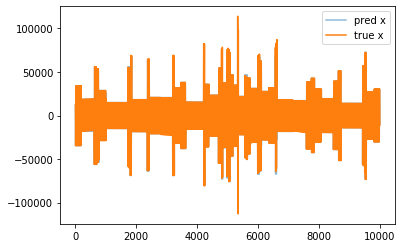

In [9]:
plt.plot(preds[:, 1], label='pred x', alpha=0.5)
plt.plot(preds1[:, 1], label='true x')
plt.legend()

In [10]:
1 - smape(preds1[:, 0], preds[:, 0])

0.8746152386625599

In [ ]:
full_train.groupby('sat_id').count()

In [79]:
transformer.fit_transform(full_train)
print(full_train.columns)

/home/paniquex/Documents/idao_oski/transformer_IDAO.py:35: RuntimeWarning: invalid value encountered in true_divide
  a /= norm
/home/paniquex/Documents/idao_oski/transformer_IDAO.py:36: RuntimeWarning: invalid value encountered in true_divide
  b /= norm
/home/paniquex/Documents/idao_oski/transformer_IDAO.py:37: RuntimeWarning: invalid value encountered in true_divide
  c /= norm


Index(['epoch', 'sat_id', 'x', 'y', 'z', 'Vx', 'Vy', 'Vz', 'x_sim', 'y_sim',
       'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim', 'x_transformed', 'y_transformed',
       'z_transformed', 'Vx_transformed', 'Vy_transformed', 'Vz_transformed'],
      dtype='object')


In [80]:
clustering1 = Clustering2D('AgglomerativeClustering', 600)
clusters_map = clustering1.fit_predict(transformer.train_coefs)

In [81]:
model = Model2D(WIDTH=3)
new_test, new_train = model.predict(full_train.copy(), full_test.copy(), clusters_map)

950 886
894 886
3871 3855
3911 3855
6225 6173
6240 6173
6921 6902
6911 6902
8447 8430
8492 8430
13110 13048
13104 13048
16714 16654
16662 16654
17334 17267
17324 17267
20061 20053
20104 20053
22776 22711
22719 22711
24775 24775
24837 24775
28461 28409
28478 28409
30606 30554
30620 30554
31936 31875
31879 31875
33701 33634
33692 33634
37305 37286
37343 37286
40122 40113
40136 40113
41070 41015
41036 41015
43195 43195
43210 43195
45122 45054
45094 45054
45697 45687
45712 45687
46617 46551
46558 46551
47440 47439
47462 47439
47989 47926
47939 47926
48653 48648
48651 48648
49904 49850
49870 49850
50715 50653
50666 50653
51860 51844
51849 51844
53326 53269
53292 53269
54147 54145
54161 54145
55753 55737
55794 55737
57163 57113
57154 57113
57774 57706
57740 57706
59171 59161
59162 59161
61313 61298
61305 61298
62594 62581
62641 62581
65505 65494
65499 65494
70076 70054
70117 70054
72871 72818
72839 72818
74148 74082
74138 74082
75775 75721
75723 75721
78738 78715
78776 78715
81308 81296
8134

592363 592302
592336 592302
593372 593310
593364 593310
594714 594707
594776 594707
598843 598842
598862 598842
603579 603531
603570 603531
605959 605953
605954 605953
607084 607082
607105 607082
611315 611310
611332 611310
619298 619237
619293 619237
624221 624219
624235 624219
625932 625890
625945 625890
626877 626866
626923 626866
628136 628120
628182 628120
629442 629427
629434 629427
630351 630302
630316 630302
631168 631111
631134 631111
632200 632189
632194 632189
638556 638497
638504 638497
644337 644316
644381 644316
650134 650128
650150 650128
655335 655322
655333 655322
658010 658006
658054 658006
660560 660555
660607 660555
661276 661221
661265 661221
662158 662151
662174 662151
665438 665369
665433 665369
668135 668113
668175 668113
670613 670605
670605 670605
673084 673022
673076 673022
674337 674315
674358 674315
678122 678111
678162 678111
681800 681745
681798 681745
682772 682716
682786 682716
684863 684849
684857 684849
686939 686887
686954 686887
687770 687768
687839

1193634 1193615
1196594 1196591
1196655 1196591
1202059 1202058
1202103 1202058
1209867 1209832
1209887 1209832
1217098 1217093
1217141 1217093
1220315 1220249
1220312 1220249
1221144 1221111
1221134 1221111
1222703 1222697
1222767 1222697
1225168 1225155
1225211 1225155
1227595 1227545
1227563 1227545
1229205 1229137
1229195 1229137
1230004 1229961
1229970 1229961
1230674 1230666
1230737 1230666
1231702 1231641
1231695 1231641
1234025 1234022
1234045 1234022
COORDS HAS ENUMERATED


In [82]:
new_test['z_pred'] = 0.0
new_test['Vz_pred'] = 0.0
new_test = transformer.inv_transform(new_test)

In [83]:
full_test = new_test

In [84]:
# # отрисовка нужного рядя для анализа
# import numpy as np
# import pandas as pd
# import lightgbm as lgbm
# import os
# import matplotlib.pyplot as plt
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots
# from datetime import datetime
# import time
# from sklearn.linear_model import LinearRegression
# from tqdm import tqdm_notebook as tqdm


# figure = plt.figure(figsize=(10, 5))


# sat_id = 3
# real_col_name = 'x_transformed'
# sim_col_name = real_col_name + '_sim'
# pred_col_name = real_col_name + '_pred'

# fig = go.Figure()
# fig.add_trace(go.Scatter(x=full_test[full_test.sat_id == sat_id].epoch,
#                              y=full_test[full_test.sat_id == sat_id]['x_pred'],
#                              name="Estimated " + real_col_name,
#                              ))

# # fig.add_trace(go.Scatter(x=full_test[full_test.sat_id == sat_id].epoch,
# #                          y=full_test[full_test.sat_id == sat_id][sim_col_name],
# #                          name="Simulation " + real_col_name,
# #                          ))

# # fig.add_trace(go.Scatter(x=full_test[full_test.sat_id == sat_id].epoch,
# #                          y=full_test[full_test.sat_id == sat_id][sim_col_name],
# #                          name="Sim_test " + real_col_name,
# #                          ))
# fig.add_trace(go.Scatter(x=full_train[full_train.sat_id == sat_id].epoch,
#                          y=full_train[full_train.sat_id == sat_id][real_col_name],
#                          name="Real " + real_col_name,
#                          ))

# # fig.add_trace(go.Scatter(x=full_train[full_train.sat_id == sat_id].epoch,
# #                          y=full_train[full_train.sat_id == sat_id][sim_col_name],
# #                          name="Simulation " + real_col_name,
# #                          ))

# fig.update_layout(title_text='Time Series for ' + real_col_name,
#                   xaxis_rangeslider_visible=True,
#                   yaxis_title=real_col_name)
# fig.show()

In [85]:
z_df = pd.read_csv('./submission (1).csv', index_col='id')

In [86]:
z_df['x'] = full_test['x_pred_transformed']
z_df['y'] = full_test['y_pred_transformed']

In [87]:
z_df.to_csv('./submission.csv', index_label='id')